In [22]:
from hossam import load_data, my_dpi
from pandas import DataFrame, get_dummies, merge
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

from kneed import KneeLocator

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [23]:
origin=load_data('customer')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

다음의 데이터는 어느 백화점의 고객에 대한 성별,나이,연수입,지출점수를 조사한 가상 데이터

===== 데이터 크기 확인 =====
데이터셋 크기 : (200, 5)
행 개수 : 200개
열 개수 : 5개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    200 non-null    int64 
 1   성별      200 non-null    object
 2   나이      200 non-null    int64 
 3   연수입     200 non-null    int64 
 4   지출점수    200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


,고객ID,성별,나이,연수입,지출점수
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [24]:
df=origin.set_index('고객ID')
df.head()

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [25]:
fields=['나이','연수입','지출점수']

for f in fields:
    stat, p=normaltest(df[f])
    alpha=0.05
    print(f'\n===== {f} 정규성 검정 =====')
    print(f'stat={stat}, p={p}')
    if p>alpha:
        print(f'{f}는 정규분포를 따릅니다 (귀무가설 채택)')
    else:
        print(f'{f}는 정규분포를 따르지 않습니다 (귀무가설 기각)')


===== 나이 정규성 검정 =====
stat=15.577514003752057, p=0.000414367622180182
나이는 정규분포를 따르지 않습니다 (귀무가설 기각)

===== 연수입 정규성 검정 =====
stat=3.5109953115353187, p=0.17282121541298148
연수입는 정규분포를 따릅니다 (귀무가설 채택)

===== 지출점수 정규성 검정 =====
stat=16.302230221326983, p=0.0002884135672001835
지출점수는 정규분포를 따르지 않습니다 (귀무가설 기각)


In [29]:
scale_df=df[['나이', '연수입', '지출점수']].copy()
scaler=StandardScaler()
sdf=DataFrame(scaler.fit_transform(scale_df), columns=scale_df.columns, index=scale_df.index)
sdf.insert(0, '성별', df['성별'])
sdf

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,-1.424569,-1.738999,-0.434801
2,Male,-1.281035,-1.738999,1.195704
3,Female,-1.352802,-1.700830,-1.715913
4,Female,-1.137502,-1.700830,1.040418
5,Female,-0.563369,-1.662660,-0.395980
...,...,...,...,...
196,Female,-0.276302,2.268791,1.118061
197,Female,0.441365,2.497807,-0.861839
198,Male,-0.491602,2.497807,0.923953


In [30]:
df_dummies=get_dummies(sdf, columns=['성별'], dtype='int', drop_first=False)
df_dummies.head()

,나이,연수입,지출점수,성별_Female,성별_Male
고객ID,,,,,
1,-1.424569,-1.738999,-0.434801,0,1
2,-1.281035,-1.738999,1.195704,0,1
3,-1.352802,-1.700830,-1.715913,1,0
4,-1.137502,-1.700830,1.040418,1,0
5,-0.563369,-1.662660,-0.395980,1,0


In [31]:
klist=list(range(3,11))
inertia=[]

for k in klist:
    estimator=KMeans(n_clusters=k, random_state=52)
    estimator.fit(X=df_dummies)
    inertia.append(estimator.inertia_)

inertia

[393.5986115835211,
 304.3074053388816,
 284.3453955595961,
 245.03129918573325,
 237.7227000085023,
 197.75874820044876,
 173.3303339679523,
 163.9166081964125]

In [33]:
kl=KneeLocator(klist, inertia, curve='convex', direction='decreasing', S=0.1)
best_k=kl.elbow
best_y=kl.elbow_y
print('found elbow :', best_k)
print('found y :', best_y)

found elbow : 4
found y : 304.3074053388816


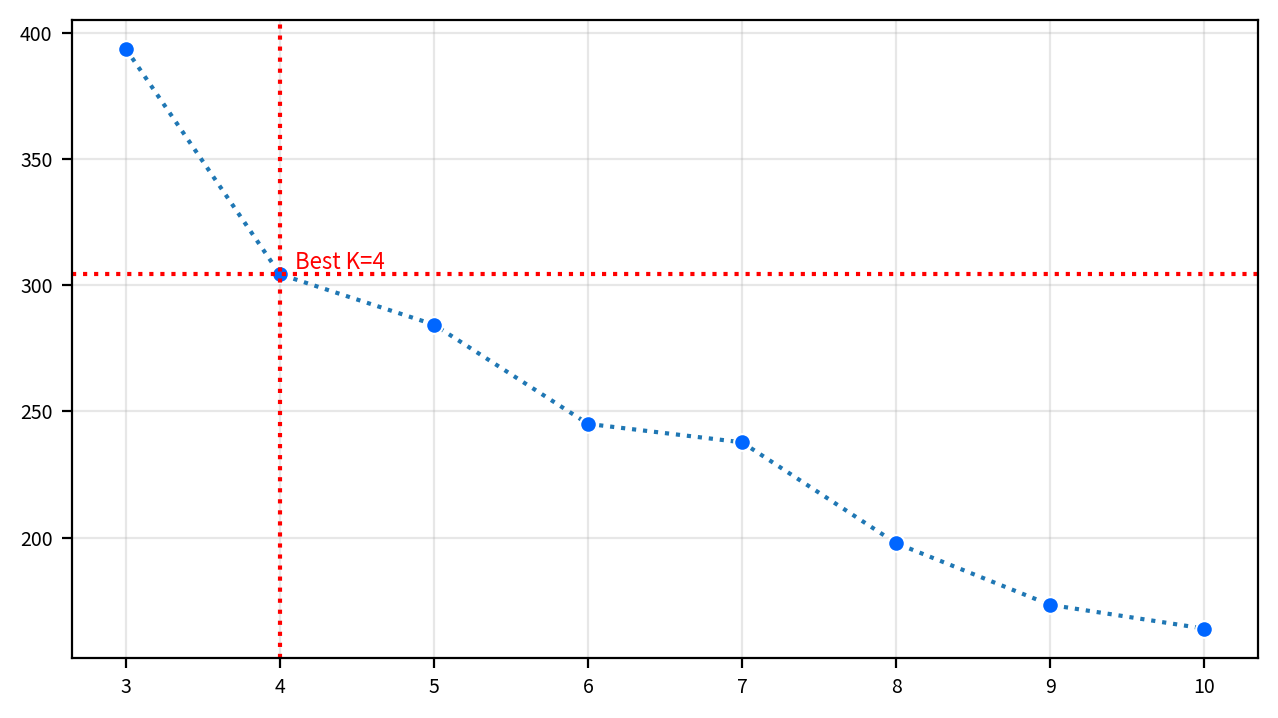

In [34]:
figsize=(1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=my_dpi)

sb.lineplot(x=klist, y=inertia, linestyle=':', marker='o', markerfacecolor='#0066ff', markeredgecolor='#ffffff')
ax.axvline(x=best_k, color='red', linestyle=':')
ax.axhline(y=best_y, color='red', linestyle=':')
ax.text(best_k+0.1, best_y+0.1, 'Best K=%d'%best_k, fontsize=8, ha='left', va='bottom', color='r')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [35]:
def visualize_silhouette(estimator, X_features):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
    
    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)
    
    y_lower = 10
    plt.suptitle(
        "Number of Cluster : " + str(estimator.n_clusters) + ", "
        "Silhouette Score :" + str(round(sil_avg, 3))
    )

    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (estimator.n_clusters + 1) * 10])
    ax1.set_yticks([]) # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_grid()

    # 클러스터링 갯수별로 fill_betweenx( ) 형태의 막대 그래프 표현.
    for i in range(estimator.n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_ == i]
        ith_cluster_sil_values.sort()
        
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / estimator.n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(estimator.labels_.astype(float) / estimator.n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]],
        X_features[X_features.columns[1]],
        marker="o",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = estimator.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="r",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

In [36]:
klist=list(range(3,11))
silhouette=[]

for k in klist:
    estimator=KMeans(n_clusters=k, random_state=52)
    estimator.fit(X=df_dummies)
    cluster=estimator.predict(df_dummies)
    s_score=silhouette_score(X=df_dummies, labels=cluster)
    silhouette.append(s_score)

silhouette_df=DataFrame({'k':klist, 'silhouette_score':silhouette})
silhouette_df

,k,silhouette_score
0,3,0.287876
1,4,0.318743
2,5,0.295763
3,6,0.309651
4,7,0.298297
5,8,0.313272
6,9,0.339913
7,10,0.336890


In [43]:
estimator=KMeans(n_clusters=4, random_state=52)
estimator.fit(X=df_dummies)
clusters=estimator.predict(df_dummies)

cdf=df_dummies.copy()
cdf['ClusterID']=clusters
cdf.head()

,나이,연수입,지출점수,성별_Female,성별_Male,ClusterID
고객ID,,,,,,
1,-1.424569,-1.738999,-0.434801,0,1,1
2,-1.281035,-1.738999,1.195704,0,1,1
3,-1.352802,-1.700830,-1.715913,1,0,1
4,-1.137502,-1.700830,1.040418,1,0,1
5,-0.563369,-1.662660,-0.395980,1,0,1


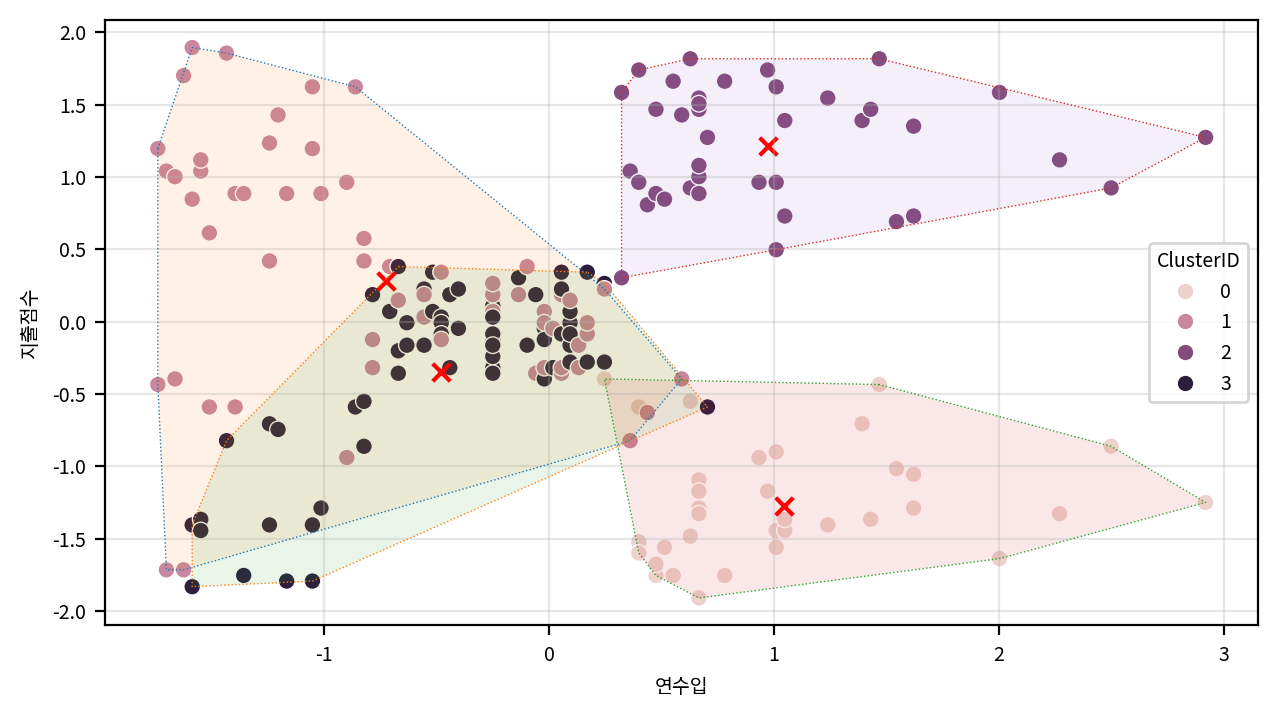

In [45]:
vdf=cdf.copy()
hue_field='ClusterID'
x_field='연수입'
y_field='지출점수'

width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)

for c in vdf[hue_field].unique():
    df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]
    try:
        # 외곽선 좌표 계산
        hull=ConvexHull(df_c)
        # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points=np.append(hull.vertices, hull.vertices[0])
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

ax.scatter(estimator.cluster_centers_[:,1], estimator.cluster_centers_[:,2], marker='x', c='red', alpha=1, s=40)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

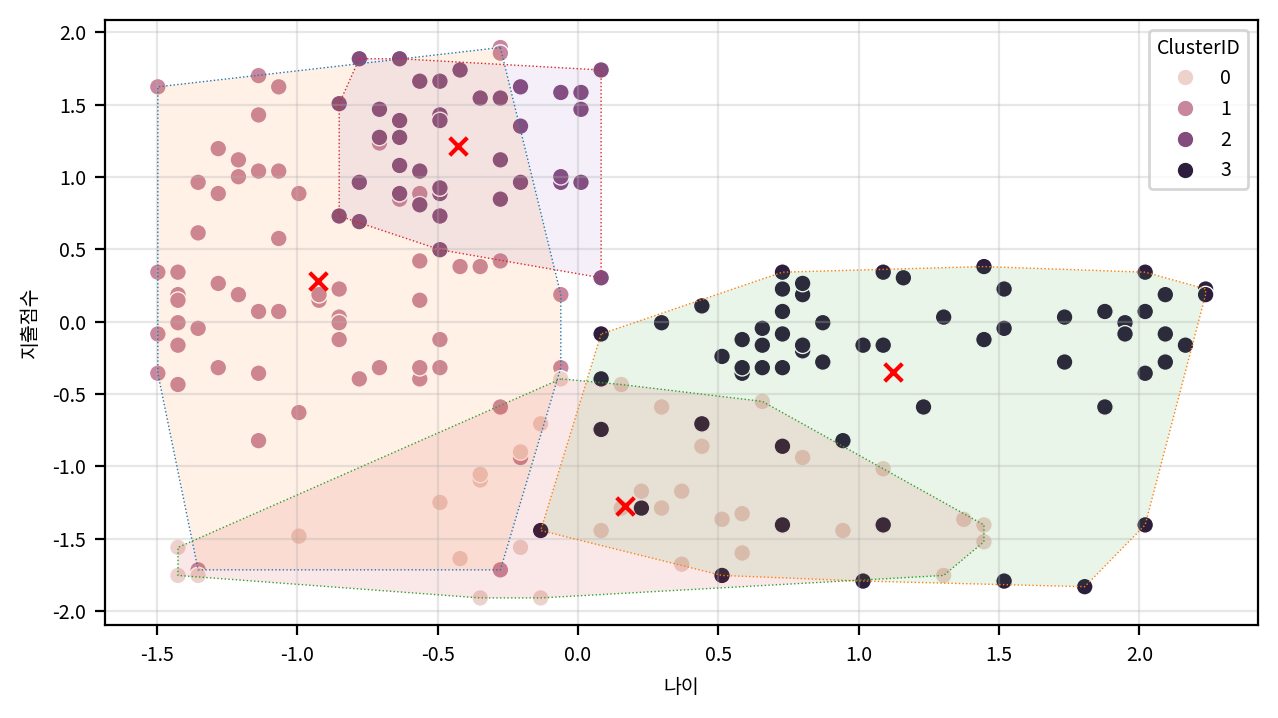

In [47]:
vdf=cdf.copy()
hue_field='ClusterID'
x_field='나이'
y_field='지출점수'

width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)

for c in vdf[hue_field].unique():
    df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]
    try:
        # 외곽선 좌표 계산
        hull=ConvexHull(df_c)
        # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points=np.append(hull.vertices, hull.vertices[0])
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

ax.scatter(estimator.cluster_centers_[:,0], estimator.cluster_centers_[:,2], marker='x', c='red', alpha=1, s=40)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [48]:
pdf=origin.copy()
pdf['ClusterID']=clusters
pdf.drop('고객ID', axis=1, inplace=True)
pdf.head()

,성별,나이,연수입,지출점수,ClusterID
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,1
3,Female,23,16,77,1
4,Female,31,17,40,1


In [49]:
persona_list=[]

for i in range(best_k):
    cluster_data=pdf[pdf['ClusterID']==i]
    persona_item={'Cluster':i}

    for column in cluster_data.columns:
        if column=='ClusterID':
            continue
        elif column=='성별':
            persona_item[f'{column}']=cluster_data[column].value_counts().idxmax()
        else:
            stat, p=normaltest(cluster_data[column])
            alpha=0.05
            if p>alpha:
                mean_value=cluster_data[column].mean()
                persona_item[f'{column}']=mean_value
            else:
                mean_value=cluster_data[column].median()
                persona_item[f'{column}']=mean_value
    persona_list.append(persona_item)

persona_df=DataFrame(persona_list)
persona_df.sort_values(by='Cluster')
persona_df

,Cluster,성별,나이,연수입,지출점수
0,0,Male,41.171429,85.000000,17.428571
1,1,Female,24.000000,40.000000,57.365079
2,2,Female,32.875000,78.500000,81.525000
3,3,Female,52.500000,47.983871,46.000000
